In [1]:
import pandas as pd
import numpy as np
dfCC = pd.read_csv('./procST4.csv')
returnMat = dfCC.to_numpy()
returnMat = returnMat[:,1:]
returnMat = returnMat.T
meanVecNP = returnMat.mean(axis=1)
covMatrix = np.cov(returnMat,bias=True)
from ipypb import irange

In [2]:
from numpy import linalg as la


def nearestPD(A):
    B = (A + A.T) / 2
    _, s, V = la.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if isPD(A3):
        return A3
    spacing = np.spacing(la.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

def isPD(B):
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [3]:
# Markovitz
import matplotlib.pyplot as plt
from gurobipy import GRB, Model

m = Model("markovitzPortfolio")
meanVec = meanVecNP.tolist()
covMatPSD = nearestPD(covMatrix).tolist()
numAsset = len(meanVec)
epsl = .01
m = Model("portfolio")
m.setParam('OutputFlag', 0)
x = m.addVars(numAsset,lb=0,ub=1, name="x") # x_j_k
m.setObjective(sum(covMatPSD[i][j]*x[i]*x[j] for i in range(numAsset) for j in range(numAsset)), GRB.MINIMIZE)
m.addConstr(sum(x[i] for i in range(numAsset)) <= 1)
m.addConstr(sum(x[i] for i in range(numAsset)) >= 1-epsl)
m.update()


--------------------------------------------
--------------------------------------------

Using license file c:\gurobi\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-08


 [████████████████████████████████████████████████████████████] 220/220 [00:10<00:00, 0.04s/it]

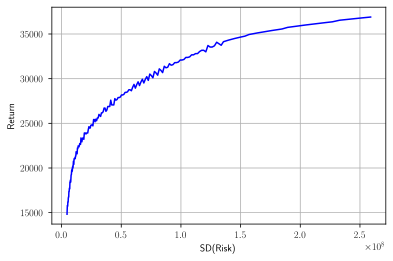

In [4]:
# MinTarget = [i for i in range(5000,45000,100)]
MinTarget = [i for i in range(15000,37000,100)]
risk_data = np.zeros(len(MinTarget))
ret_data = np.zeros(len(MinTarget))
count_divers = np.zeros(len(MinTarget))
dfExp = pd.DataFrame()
for j in irange(len(MinTarget)):
#     print(MinTarget[j])
    m.addConstr(sum(x[i]*meanVec[i] for i in range(numAsset)) >= MinTarget[j],'BudgetConstr')
    try:
        m.optimize()
        Invest = m.getAttr('x',x)
        risk = m.objVal
        m.remove(m.getConstrByName('BudgetConstr'))
        m.update()
        risk_data[j] = risk
        investNP = np.array(Invest.values())
        ret_data[j] = meanVecNP.T.dot(np.round(investNP,2))
        count_divers[j] = np.sum(np.array(investNP) > .001, axis=0)
        dfExp[str(MinTarget[j]) +"_"+ str(np.round(risk))] = np.round(investNP,3)
    except:
        break
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
plt.rc('text', usetex=True)
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'b-')
plt.xlabel('SD(Risk)')
plt.ylabel('Return')
plt.grid()
# plt.show()
plt.savefig("dfMarkovitz_return_risk2.pdf", bbox_inches = 'tight',pad_inches = 0)
del m

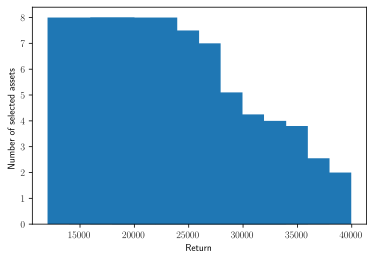

In [34]:
ret_data_bin = np.mean(np.stack( np.array_split(ret_data, 11), axis=0 ),axis=1)
count_divers_bin = np.mean(np.stack( np.array_split(count_divers, 11), axis=0 ),axis=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.rc('text', usetex=True)
plt.bar(ret_data_bin , count_divers_bin,8000)
plt.xlabel('Return')
plt.ylabel('Number of selected assets')
# plt.show()
plt.savefig("dfMarkovitz_diversity2.pdf", bbox_inches = 'tight',pad_inches = 0)

In [31]:
dfExp.to_csv("dfMarkovitz2.csv")

In [32]:
len(ret_data)

220

In [33]:
355/5

71.0